In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../fibermetric/')
sys.path.append('/home/brysongray/periodic-kmeans/')
import histology
import sta_validate
from sta_validate import parallel_lines_3D
from periodic_kmeans.periodic_kmeans import PeriodicKMeans
# from spherecluster import SphericalKMeans
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib widget
import pandas as pd
import cProfile
import tqdm
import time

# 2D Phantom Tests

TypeError: Invalid shape (64,) for image data

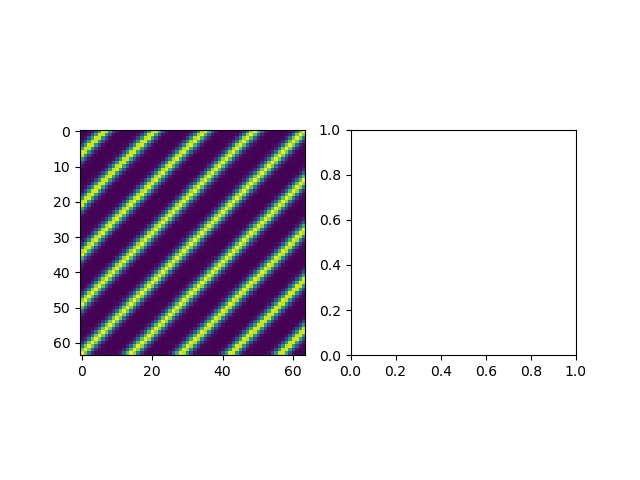

In [3]:
I,_,extent = sta_validate.parallel_lines_2d(thetas=[-np.pi/4], nI=(64,64), period=10, noise=0.001)
S = histology.structure_tensor(I)
angles = histology.angles(S)[0]
fig, ax = plt.subplots(1,2)
ax[0].imshow(I)
ax[1].imshow(angles)

In [ ]:
width = 2
# derivative_sigmas = np.linspace(start=0.25, stop=5.0, num=10)
# tensor_sigmas = np.linspace(start=5.0, stop=17.0, num=10)
periods = [6,10,14]
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists

anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240)]
AI_ratio = [a[1]/a[0] for a in anisotropy]
print(derivative_sigmas)
print(tensor_sigmas)
print(AI_ratio)
d = 1
t = 3
a = 0
p = 2
# g = 7
err_type = 'piecewise'
error_by_theta = []
for g in range(len(grid_thetas)):
    if g == 6:
        display=True
    else:
        display=False
    error_by_theta.append(sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=[np.pi/2], err_type=err_type, display=display)) # , grid_thetas=(-np.pi/6,np.pi/3)
avg_error = np.mean(error_by_theta)
print(avg_error)
# with cProfile.Profile() as pr:
#     error = sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=periods[p], noise=1e-9, width=width, phantom='grid', grid_thetas=grid_thetas[g], err_type=err_type, display=True) # , grid_thetas=(-np.pi/6,np.pi/3)
#     print(f'{err_type} error: {error}')
#     pr.print_stats()

In [ ]:
width = 1
periods = [6,10,14]
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
# mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
# deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
# grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
# grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists
# periods = [14]
# derivative_sigmas = [1.0]
# tensor_sigmas = [1.0]
grid_thetas = [[0],[np.pi/12],[np.pi/6],[np.pi/4], [np.pi/3], [5*np.pi/12]]

anisotropy = [(180,240)]
errors = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=anisotropy, periods=periods, widths=width, noises=1e-9, phantom='grid', grid_thetas=grid_thetas, err_type='piecewise')
# np.save(f'grid_errors_delta0.npy', errors, allow_pickle=True)

In [ ]:
err_type = 'piecewise'
error = sta_validate.phantom_test(0.5, 1.0, (120,240), period=10, noise=1e-9, width=1, phantom='grid', grid_thetas=[-np.pi/2], err_type='piecewise', display=True, crop=None, tile_size=None) # , grid_thetas=(-np.pi/6,np.pi/3)
print(error)

# 3D Line Drawing

In [ ]:
nI = [25,100,100]
dI = [4.0,1.0,1.0]
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), -1)
labels = np.zeros(nI+[2,])
# theta = np.pi/2
theta = np.pi/3
phi = 0
angles = [theta, phi]
# sigma = (np.sin(theta)*dI[0])**2 + (np.cos(theta)*dI[1])**2
inv_sigma = np.array([[1/dI[0], 0],
                  [0, 1/dI[1]]])
norm = 2*np.pi * np.sqrt(np.sum(1/np.diag(inv_sigma)))
line_thresh = np.exp(-0.5)/norm
v = np.array([np.cos(theta), np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)])[None]
c0 = np.array([(n-1)*d/2 for n,d in zip(nI,dI)]) # center of the image
projection = (XI - c0) - ((XI - c0)@v.T)*v
xy_dist = np.linalg.norm(projection[...,1:], axis=-1) # distance from each pixel to the line
z_dist = projection[...,0] 
dist = np.stack([z_dist,xy_dist],-1)[...,None,:]
# line = np.exp(-0.5 * dist**2 / sigma) / np.sqrt(2.0*np.pi*sigma)
line = np.exp(-0.5 * dist @ inv_sigma @ dist.transpose(0,1,2,4,3)).squeeze() / norm
line_label = np.where(line[...,None] > line_thresh, [theta,np.pi/2-phi], [0.0,0.0])
labels += line_label
labels = np.where(np.any(labels[...,None] == np.array(angles), axis=3), labels, [0.0,0.0])
extent = [0, nI[0]*dI[0], 0, nI[1]*dI[1]]
# plt.figure()
# plt.imshow(dist[50,:,:], vmin=-10, vmax=10, extent=extent)
fig, axs = plt.subplots(3)
axs[0].imshow(line[nI[0]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(line[:,nI[1]//2,:], extent=extent)
axs[1].set_title('zx')
axs[2].imshow(line[:,:,nI[2]//2], extent=extent)
axs[2].set_title('zy')

In [3]:
nI = [32,64,64]
dI = [nI[1]/nI[0],1.0,1.0]
theta = 3*np.pi/4
phi = 0
theta2 = 0
phi2 = 0

I, _ = parallel_lines_3D([(theta,phi),(theta2,phi2)], nI, 10, display=False)

increment in xz plane
increment in xy plane
49


Text(0.5, 1.0, 'zy')

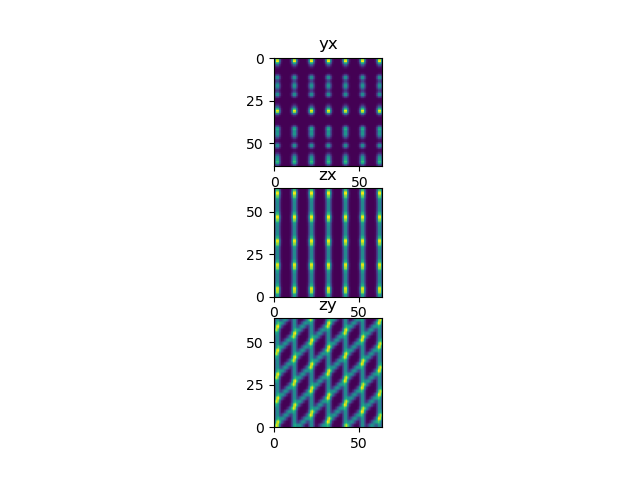

In [13]:
fig, axs = plt.subplots(3)
axs[0].imshow(I[nI[0]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(I[:,nI[1]//2,:], extent=[0,nI[2]*dI[2],0,nI[0]*dI[0]])
axs[1].set_title('zx')
axs[2].imshow(I[:,:,nI[2]//2], extent=[0,nI[1]*dI[1],0,nI[0]*dI[0]])
axs[2].set_title('zy')

In [4]:
I_corrected,_,extent = sta_validate.anisotropy_correction(I, dI)

In [ ]:
fig, axs = plt.subplots(3)
axs[0].imshow(I_corrected[nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(I_corrected[:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(I_corrected[:,:,nI[2]//2])
axs[2].set_title('zy')

In [ ]:
I_blurred,_,extent = sta_validate.anisotropy_correction(I, dI, blur=(0.,dI[0]-dI[1],dI[0]-dI[1]))

In [ ]:
fig, axs = plt.subplots(3)
axs[0].imshow(I_blurred[nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(I_blurred[:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(I_blurred[:,:,nI[2]//2])
axs[2].set_title('zy')

In [ ]:
# visualize with volume plot
Z,Y,X = np.mgrid[0:32:1,0:64:1,0:64:1]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=I_blurred.flatten(),
    isomin=0.002,
    isomax=0.008,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()

### test 3D structure tensor analysis

In [11]:
S = histology.structure_tensor(I_corrected, derivative_sigma=1.0, tensor_sigma=1.0)
angles = histology.angles(S, cartesian=True)
print(angles.shape)

(64, 64, 64, 3)


In [ ]:
print(f'true theta: {theta}')
fig, axs = plt.subplots(3)
axs[0].imshow(angles[0,nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(angles[0,:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(angles[0,:,:,nI[2]//2])
axs[2].set_title('zy')

In [ ]:
print(f'true phi: {phi}')
fig, axs = plt.subplots(3)
axs[0].imshow(angles[1,nI[1]//2,:,:])
axs[0].set_title('yx')
axs[1].imshow(angles[1,:,nI[1]//2,:])
axs[1].set_title('zx')
axs[2].imshow(angles[1,:,:,nI[2]//2])
axs[2].set_title('zy')

### 3D structure tensor error estimation

In [13]:
crop = 0
tile_size = 16
# crop boundaries to remove artifacts related to averaging tensors near the edges.
if crop is None:
    crop = 16
elif crop > 0:
    angles = angles[:,crop:-crop, crop:-crop, crop:-crop]
# partition angles into tiles
i, j, k = [x//tile_size for x in angles.shape[:-1]]
angles_ = np.array(angles[:i*tile_size, :j*tile_size, :k*tile_size]) # crop so angles divides evenly into tile_size (must create a new array to change stride lengths too.)
# reshape into tiles by manipulating strides. (np.reshape preserves contiguity of elements, which we don't want in this case)
nbits = angles_.strides[-1]
angles_ = np.lib.stride_tricks.as_strided(angles_, shape=(i, j, k, tile_size, tile_size, tile_size, angles.shape[-1]),
                                          strides=(tile_size*angles_.shape[1]*angles_.shape[2]*angles_.shape[3]*nbits,
                                                   tile_size*angles_.shape[2]*angles_.shape[3]*nbits,
                                                   tile_size*angles_.shape[3]*nbits,
                                                   angles_.shape[1]*angles_.shape[2]*angles_.shape[3]*nbits,
                                                   angles_.shape[2]*angles_.shape[3]*nbits,
                                                   angles_.shape[3]*nbits,
                                                   nbits))
angles_ = angles_.reshape(i,j,k,tile_size**3,angles.shape[-1])
print(angles_.shape)

(4, 4, 4, 4096, 3)


In [4]:
grid_thetas = [(0,0),(np.pi/4,0),(np.pi/4,np.pi/2),(np.pi/2,np.pi/2)]
grid_thetas = np.array(grid_thetas)
grid_vectors = np.array([np.sin(grid_thetas[:,0])*np.sin(grid_thetas[:,1]),
                        np.sin(grid_thetas[:,0])*np.cos(grid_thetas[:,1]),
                        np.cos(grid_thetas[:,0])
                        ]).T
print(grid_vectors)


[[0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 7.07106781e-01 7.07106781e-01]
 [7.07106781e-01 4.32978028e-17 7.07106781e-01]
 [1.00000000e+00 6.12323400e-17 6.12323400e-17]]


## Phantom Test

### profiling phantom test

In [4]:
with cProfile.Profile() as pr:
    error = sta_validate.phantom_test(derivative_sigma=0.5, tensor_sigma=1.0, period=10, nI=(128,128,128), grid_thetas=[[3*np.pi/2,0], [np.pi/3,np.pi/6]], display=False, return_all=False)
    print(error)
    pr.print_stats(sort='tottime')

increment in xy plane
increment in xz plane
line count: 323
5.137863646950448
         18975 function calls (18376 primitive calls) in 172.520 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      570  133.487    0.234  166.028    0.291 sta_validate.py:176(draw_line_3D)
      570   13.689    0.024   27.101    0.048 linalg.py:2357(norm)
      625   13.552    0.022   13.552    0.022 {method 'reduce' of 'numpy.ufunc' objects}
1825/1232    5.539    0.003   36.345    0.030 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    3.404    3.404    3.404    3.404 linalg.py:1331(eigh)
        5    1.577    0.315    1.813    0.363 apsym_kmeans.py:25(_apsym_lloyd_iter)
        1    0.360    0.360  166.455  166.455 sta_validate.py:575(parallel_lines_3D)
       27    0.340    0.013    0.340    0.013 {built-in method scipy.ndimage._nd_image.correlate1d}
        1    0.089    0.089    2.090    2.090 apsym_kmea

In [ ]:
# Profile draw_line_3D

nI = [64,64,64]
dI = [nI[1]/nI[0], 1.0, 1.0]
xI = [np.arange(n)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI, indexing='ij'), axis=-1)
I = np.zeros(nI)
theta = np.pi/2
phi = 0.0
direction = np.array([np.cos(theta), np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi)])[None]
point = (32,32,32)
inv_sigma = np.array([[1.0, 0.],
                      [0., 1.0]])

In [26]:
with cProfile.Profile() as pr:
    for i in range(100):
        I, _ = sta_validate.draw_line_3D(I, XI , direction, point, inv_sigma, norm)

pr.print_stats(sort='tottime')


         2902 function calls (2802 primitive calls) in 3.155 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      100    2.612    0.026    3.155    0.032 sta_validate.py:173(draw_line_3D)
      100    0.242    0.002    0.242    0.002 {method 'reduce' of 'numpy.ufunc' objects}
      100    0.235    0.002    0.477    0.005 linalg.py:2357(norm)
  300/200    0.062    0.000    0.541    0.003 {built-in method numpy.core._multiarray_umath.implement_array_function}
      100    0.001    0.000    0.063    0.001 shape_base.py:357(stack)
      100    0.001    0.000    0.478    0.005 <__array_function__ internals>:177(norm)
      100    0.000    0.000    0.061    0.001 <__array_function__ internals>:177(concatenate)
      100    0.000    0.000    0.064    0.001 <__array_function__ internals>:177(stack)
      100    0.000    0.000    0.000    0.000 shape_base.py:348(_stack_dispatcher)
      100    0.000    0.000    0.000    0.000 shape

In [68]:
shape = [72,72,72]
d = [shape[1]/shape[0], 1.0, 1.0]
x = [np.arange(n)*di for n,di in zip(shape,d)]
angles = [[np.pi/2,np.pi/2], [0.0, 0.0]]
with cProfile.Profile() as pr:
        phantom = sta_validate.make_phantom(x, angles, period=8, width=1.0, noise=0.001, display=False, return_labels=False)
pr.print_stats(sort='tottime')

         493 function calls (478 primitive calls) in 0.131 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.114    0.114    0.131    0.131 sta_validate.py:956(make_phantom)
        1    0.007    0.007    0.007    0.007 {method 'randn' of 'numpy.random.mtrand.RandomState' objects}
        1    0.006    0.006    0.006    0.006 {built-in method torch._C._nn.upsample_trilinear3d}
    23/14    0.002    0.000    0.003    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        3    0.001    0.000    0.001    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    0.000    0.000    0.000    0.000 {built-in method torch.tensor}
        2    0.000    0.000    0.000    0.000 _matfuncs.py:215(expm)
        1    0.000    0.000    0.006    0.006 sta_validate.py:747(anisotropy_correction)
        2    0.000    0.000    0.000    0.000 numeric.py:1485(cross)
        2    0.000    0.000    0.

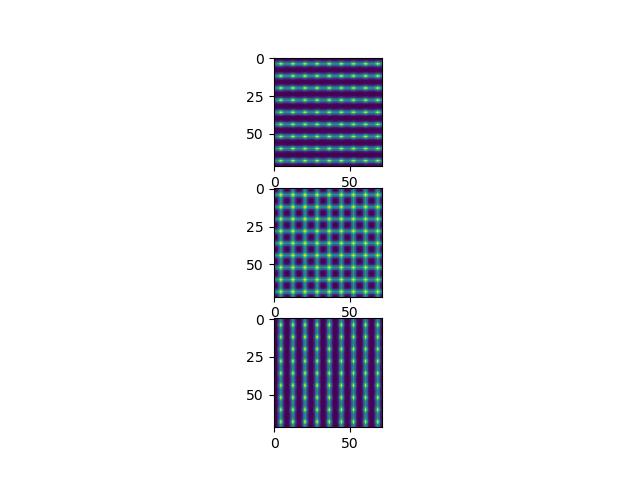

In [70]:
fig,ax = plt.subplots(3)
ax[0].imshow(phantom[36,:,:])
ax[1].imshow(phantom[:,36,:])
ax[2].imshow(phantom[:,:,36])

In [76]:
d = 1.0
t = 1.0
with cProfile.Profile() as pr:
    error = sta_validate.sta_test(phantom, d, t, true_thetas=angles)
    print(error)
pr.print_stats(sort='tottime')

22.89654350199985
         2733 function calls (2703 primitive calls) in 1.424 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.611    0.611    0.611    0.611 linalg.py:1331(eigh)
       12    0.607    0.051    0.702    0.058 apsym_kmeans.py:25(_apsym_lloyd_iter)
       82    0.057    0.001    0.057    0.001 {method 'reduce' of 'numpy.ufunc' objects}
       27    0.041    0.002    0.041    0.002 {built-in method scipy.ndimage._nd_image.correlate1d}
       14    0.032    0.002    0.032    0.002 {method 'argmin' of 'numpy.ndarray' objects}
        1    0.016    0.016    0.748    0.748 apsym_kmeans.py:496(fit)
  175/145    0.016    0.000    0.725    0.005 {built-in method numpy.core._multiarray_umath.implement_array_function}
       40    0.012    0.000    0.012    0.000 {method 'copy' of 'numpy.ndarray' objects}
        1    0.007    0.007    0.065    0.065 histology.py:47(structure_tensor)
        2    0.004   

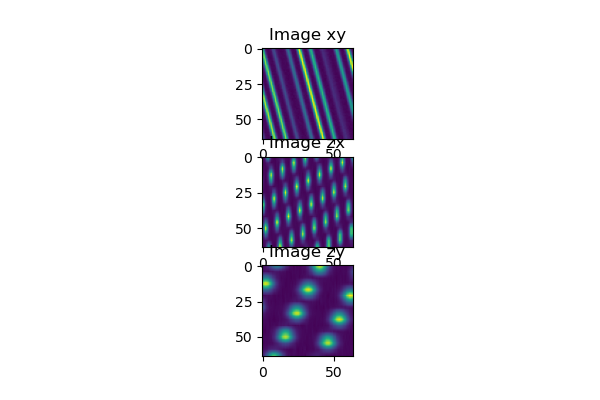

In [27]:
n = [16,64,64]
d = [2.0, 1.0, 1.0]
x = [np.arange(ni)*di for ni,di in zip(n,d)]
angles=[(np.pi/2,np.pi/12),]
# angles = [0., np.pi/3]
I = sta_validate.make_phantom(x, angles, display=True, return_labels=False, period=8)

### choose parameters for 3D testing

In [9]:
I = sta_validate.make_phantom(nI=[64,64,64], period=10, width=1.0, noise=0.001, grid_thetas=[[np.pi/2,np.pi/3], [0.0, 0.0]], display=False, return_labels=False)

increment in yz plane
increment in xy plane
line count: 49


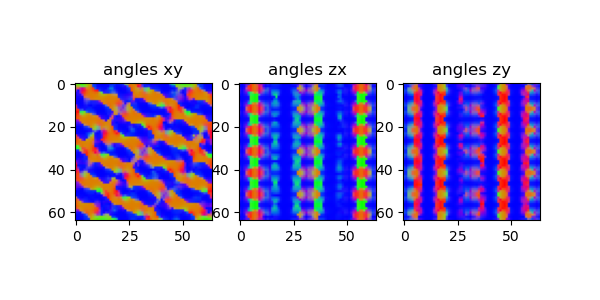

error = 0.14673674329401265 degrees


In [10]:
error = sta_validate.sta_test(I, derivative_sigma=1.0, tensor_sigma=1.0, true_thetas=[[np.pi/2,np.pi/3], [0.0, 0.0]], display=True)

increment in yz plane


increment in xy plane
line count: 255
error = 6.527772788627814 degrees


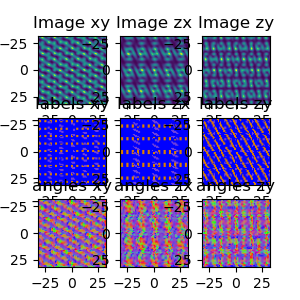

In [28]:
error = sta_validate.phantom_test(derivative_sigma=0.15, tensor_sigma=0.5, period=5, nI=[64,64,64], width=1.0, grid_thetas=[[np.pi/2,np.pi/3], [np.pi/6,np.pi/3]], display=True, return_all=False)

In [1]:
# we'll choose one average phi that is not aligned with the grid
periods = [5,10,15]
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=10.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[([mean - delta/2, np.pi/3], [mean + delta/2, np.pi/3]) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists
# choose a few thetas

NameError: name 'np' is not defined

In [37]:
len(grid_thetas[0][0])

2

## Test different mixture modelling methods

In [ ]:
width = 2
periods = 15
derivative_sigmas = np.linspace(start=0.15, stop=2.5, num=10)
tensor_sigmas = np.linspace(start=0.0, stop=8.0, num=10)
mean_thetas = np.array([np.pi/6, np.pi/4, np.pi/3])
deltas = np.array([np.pi/12, np.pi/6, np.pi/4, np.pi/3])
grid_thetas = [[(mean - delta/2, mean + delta/2) for delta in deltas] for mean in mean_thetas]
grid_thetas = [item for sublist in grid_thetas for item in sublist] # flatten list of lists

anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240)]
# errors = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=anisotropy, periods=periods, widths=width, noises=0.0, phantom='grid', grid_thetas=grid_thetas, err_type='piecewise')


In [ ]:
from scipy.stats import vonmises
from sklearn.cluster import KMeans
import time

mu = np.random.rand(2)*np.pi
mu.sort()
kmeans_diff = []
mle_diff = []
periodic_kmeans_diff = []
kmeans_time = []
mle_time = []
periodic_kmeans_time = []
for i in tqdm.tqdm(range(100)):
    vm1 = vonmises.rvs(6.0, loc=mu[0], size=100)
    vm2 = vonmises.rvs(6.0, loc=mu[1], size=100)
    vm = np.concatenate((vm1,vm2))
    vm = np.where(vm < 0, vm + np.pi, vm)
    time1 = time.time()
    kmeans = KMeans(n_clusters=2, random_state=0, algorithm='elkan').fit(vm.reshape(-1,1))
    time2 = time.time()
    mu_kmeans = kmeans.cluster_centers_.reshape(-1)
    mu_kmeans.sort()
    time3 = time.time()
    mu_mle, kappa, pi = histology.vm_maximum_likelihood(vm, verbose=False)
    time4 = time.time()
    mu_mle.sort()
    time5 = time.time()
    periodic_kmeans = PeriodicKMeans(vm.reshape(-1,1), period=np.pi, no_of_clusters=2)
    clust_data, wccs_circ, centers = periodic_kmeans.clustering()
    time6 = time.time()
    mu_periodic_kmeans = np.array(centers).squeeze()
    mu_periodic_kmeans.sort()
    if i==0:
        plt.figure()
        plt.hist(vm, bins='auto', density=True)
        plt.plot([mu[0]]*100, np.linspace(0,0.4,num=100), label='mu1')
        plt.plot([mu[1]]*100, np.linspace(0,0.4,num=100), label='mu2')
        plt.plot([mu_kmeans[0]]*100, np.linspace(0,0.4,num=100), label='kmeans 1')
        plt.plot([mu_kmeans[1]]*100, np.linspace(0,0.4,num=100), label='kmeans 2')
        plt.plot([mu_periodic_kmeans[0]]*100, np.linspace(0,0.4,num=100), label='periodic kmeans 1')
        plt.plot([mu_periodic_kmeans[1]]*100, np.linspace(0,0.4,num=100), label='periodic kmeans 2')
        plt.plot([mu_mle[0]]*100, np.linspace(0,0.4,num=100), label='mle 1')
        plt.plot([mu_mle[1]]*100, np.linspace(0,0.4,num=100), label='mle 2')
        plt.legend()
        plt.show()
    kmeans_diff.append([np.min((np.abs(mu_kmeans[0]-mu[0]), np.pi-np.abs(mu_kmeans[0]-mu[0]))), np.min((np.abs(mu_kmeans[1]-mu[1]), np.pi-np.abs(mu_kmeans[1]-mu[1])))])
    mle_diff.append([np.min((np.abs(mu_mle[0]-mu[0]), np.pi-np.abs(mu_mle[0]-mu[0]))), np.min((np.abs(mu_mle[1]-mu[1]), np.pi-np.abs(mu_mle[1]-mu[1])))])
    periodic_kmeans_diff.append([np.min((np.abs(mu_periodic_kmeans[0]-mu[0]), np.pi-np.abs(mu_periodic_kmeans[0]-mu[0]))), np.min((np.abs(mu_periodic_kmeans[1]-mu[1]), np.pi-np.abs(mu_periodic_kmeans[1]-mu[1])))])
    kmeans_time.append(time2-time1)
    mle_time.append(time4-time3)
    periodic_kmeans_time.append(time6-time5)
kmeans_diff = np.array(kmeans_diff)
mle_diff = np.array(mle_diff)
periodic_kmeans_diff = np.array(periodic_kmeans_diff)

In [ ]:
print(f'kmeans mu1 difference: {np.mean(kmeans_diff[0])}\n kmeans mu2 difference: {np.mean(kmeans_diff[1])}')
print(f'mle mu1 difference: {np.mean(mle_diff[0])}\n mle mu2 difference: {np.mean(mle_diff[1])}')
print(f'periodic_kmeans mu1 difference: {np.mean(periodic_kmeans_diff[0])}\n periodic_kmeans mu2 difference: {np.mean(periodic_kmeans_diff[1])}')
print(f'kmeans time: {np.mean(kmeans_time)}')
print(f'mle time: {np.mean(mle_time)}')
print(f'periodic_kmeans time: {np.mean(periodic_kmeans_time)}')